# **A Neural Network that predicts handwritten digits**

In [4]:
# To import important libraries.

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# Function to load MNIST dataset.

def load_data():

    """
    This function helps to Load the MNIST dataset and preprocesses it for use in a neural network.

    Returns:
    - x_train, x_test: Training images, testing images.
    - y_train, y_test: Training labels, Testing labels.
    """

    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # To normalize pixel values.

    # To flatten images to 1D array.
    x_train = x_train.reshape(-1, 784)
    x_test = x_test.reshape(-1, 784)

    return x_train, y_train, x_test, y_test


In [6]:
# Function to split the dataset into a small labeled set and a large unlabeled set.

def split_data(x_train, y_train, num_labeled=1000):

    """
    this function helps to split the dataset into a small labeled set and a large unlabeled set.

    Parameters:
    - x_train: Training images.
    - y_train: Training labels.
    - num_labeled: Number of labeled samples to include in the labeled set.

    Returns:
    - x_labeled: Labeled images.
    - x_unlabeled: Unlabeled images.
    - y_labeled: Labeled labels.
    """

    x_labeled, x_unlabeled, y_labeled, _ = train_test_split(
        x_train, y_train, train_size=num_labeled, stratify=y_train
    )
    return x_labeled, x_unlabeled, y_labeled

In [7]:
# Function to create a simple Multilayer Neural Network model.

def create_model():

    """
    This function helps to create a simple Multilayer Neural Network model for image classification.

    Returns:
    - model: The compiled Keras model.
    """

    model = keras.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
# Function to train the model using the labeled data.

def train_model(model, x_labeled, y_labeled, x_test, y_test, epochs=15, batch_size=32):

    """
    This function helps to train the provided Keras model on the labeled data.

    Parameters:
    - model: The Keras model to be trained.
    - x_labeled: Labeled images.
    - y_labeled: Labeled labels.
    - x_test: Testing images.
    - y_test: Testing labels.

    Returns:
    - model: Trained model.
    """

    print("Training model on labeled data...")

    return model.fit(x_labeled, y_labeled, epochs=epochs, validation_data=(x_test, y_test), batch_size=batch_size)

In [9]:
# Functon to generate pseudo-labels for the unlabeled data.

def generate_pseudo_labels(model, x_unlabeled, threshold=0.80):

    """
    This function helps to generates pseudo-labels for the unlabeled data using the trained model.

    Parameters:
    - model: The trained Keras model.
    - x_unlabeled: Unlabeled images.

    Returns:
    - x_pseudo: Pseudo-labeled images.
    - y_pseudo: Pseudo-labeled labels.
    """

    print("Generating pseudo-labels...")
    predictions = model.predict(x_unlabeled)
    pseudo_labels = np.argmax(predictions, axis=1)
    high_confidence_mask = np.max(predictions, axis=1) > threshold

    return x_unlabeled[high_confidence_mask], pseudo_labels[high_confidence_mask]


In [10]:
# Function to apply data augmentation to the pseudo-labeled data.

def augment_data(x_pseudo):

    """
    This function helps to Apply data augmentation to the pseudo-labeled data.

    Parameters:
    - x_pseudo: Pseudo-labeled images.

    Returns:
    - x_pseudo_aug: Augmented pseudo-labeled images.
    """

    aug = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1
    )
    print("Applying data augmentation...")
    x_pseudo_aug = np.array([
        aug.random_transform(np.expand_dims(img.reshape(28, 28), axis=-1)).squeeze().flatten() for img in x_pseudo
    ])

    return x_pseudo_aug

In [11]:
# Function to combine labeled and pseudo-labeled data.

def combine_data(x_labeled, y_labeled, x_pseudo_aug, y_pseudo):

    """
    This function helps to combine the labeled and pseudo-labeled data.

    Parameters:
    - x_labeled: Labeled images.
    - y_labeled: Labeled labels.
    - x_pseudo_aug: Augmented pseudo-labeled images.
    - y_pseudo: Pseudo-labeled labels.

    Returns:
    - x_combined: Combined images.
    - y_combined: Combined labels.
    """

    print("Combining labeled and pseudo-labeled datasets...")

    return np.concatenate([x_labeled, x_pseudo_aug]), np.concatenate([y_labeled, y_pseudo])

In [12]:
# Function to retrain the model with the combined data.

def retrain_model(model, x_combined, y_combined, x_test, y_test, epochs=15, batch_size=32):

    """
    This function helps to retrain the model with the combined data.

    Parameters:
    - model: The trained Keras model.
    - x_combined: Combined images.
    - y_combined: Combined labels.

    Returns:
    - history: Training history.
    """

    print("Retraining model with labeled and pseudo-labeled data...")

    return model.fit(x_combined, y_combined, epochs=epochs, validation_data=(x_test, y_test), batch_size=batch_size)

In [13]:
# Function to evaluate the final model performance.

def evaluate_model(model, x_test, y_test):

    """
    This function helps to evaluate the final model's performance on the test data.

    Parameters:
    - model: The final trained Keras model.
    - x_test: Testing images.
    - y_test: Testing labels.
    """

    print("Evaluating final model...")
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Final test accuracy: {test_acc:.4f}")

In [14]:
# Function to plot accuracy comparison.

def plot_accuracy(history, history_pseudo):

    """
    This function helps to plot the accuracy comparison between the supervised learning (labeled only)
    and semi-supervised learning (with pseudo-labels and augmentation) models.

    Parameters:
    - history: Training history for the supervised learning model.
    - history_pseudo: Training history for the semi-supervised learning model.
    """

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['val_accuracy'], label='Supervised Learning (Labeled Only)', marker='o')
    plt.plot(history_pseudo.history['val_accuracy'], label='Semi-Supervised Learning (With Pseudo-Labels & Augmentation)', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title('Accuracy Improvement with Pseudo-Labeling & Data Augmentation')
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
# Main function to orchestrate the process.

def main():
    """
    Main function to run the entire process.
    """
    # Load the data
    x_train, y_train, x_test, y_test = load_data()

    # Split into labeled and unlabeled sets
    x_labeled, x_unlabeled, y_labeled = split_data(x_train, y_train)

    # Create and train the initial model on labeled data
    model = create_model()
    history = train_model(model, x_labeled, y_labeled, x_test, y_test)

    # Generate pseudo-labels for the unlabeled data
    x_pseudo, y_pseudo = generate_pseudo_labels(model, x_unlabeled)

    # Augment the pseudo-labeled data
    x_pseudo_aug = augment_data(x_pseudo)

    # Combine labeled and pseudo-labeled data
    x_combined, y_combined = combine_data(x_labeled, y_labeled, x_pseudo_aug, y_pseudo)

    # Retrain the model with the combined dataset
    model = create_model()
    history_pseudo = retrain_model(model, x_combined, y_combined, x_test, y_test)

    # Evaluate the model
    evaluate_model(model, x_test, y_test)

    # Plot the accuracy comparison
    plot_accuracy(history, history_pseudo)

Training model on labeled data...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3763 - loss: 1.8169 - val_accuracy: 0.8404 - val_loss: 0.5912
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7948 - loss: 0.6448 - val_accuracy: 0.8678 - val_loss: 0.4432
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8778 - loss: 0.3948 - val_accuracy: 0.8858 - val_loss: 0.3771
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8957 - loss: 0.3242 - val_accuracy: 0.8938 - val_loss: 0.3574
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9305 - loss: 0.2163 - val_accuracy: 0.9014 - val_loss: 0.3282
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9522 - loss: 0.1380 - val_accuracy: 0.8885 - val_loss: 0.3848
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9550 - loss: 0.1361 - val_accuracy: 0.9043 - val_loss: 0.3390
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9822 - loss: 0.0828 - val_accuracy: 0.8973 - val_loss: 0

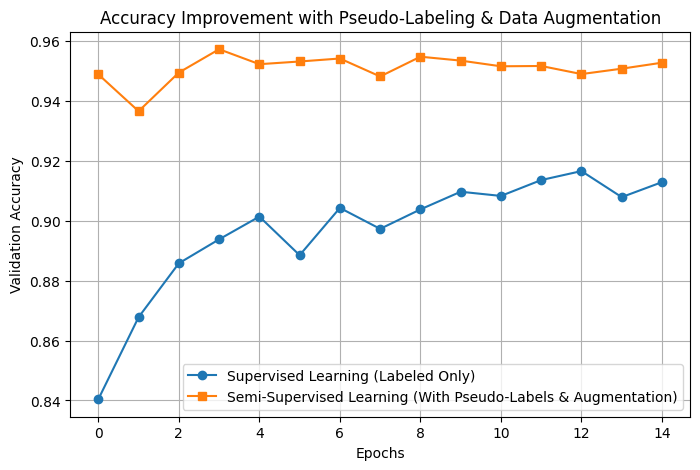

In [16]:
main()